<a href="https://colab.research.google.com/github/haonan2012/Dive2DeepLearning/blob/master/3_0_MLP_and_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilities

In [1]:
import inspect

def add_to_class(Class):
  """Register functions as methods in created class."""
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper


class HyperParameters:
  """The base class of hyperparameters."""
  def save_hyperparameters(self, ignore=[]):
    """Save function arguments into class attributes."""
    frame = inspect.currentframe().f_back
    _, _, _, local_vars = inspect.getargvalues(frame)
    self.hparams = {k:v for k, v in local_vars.items()
            if k not in set(ignore+['self']) and not k.startswith('_')}
    for k, v in self.hparams.items():
      setattr(self, k, v)


from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import display
import collections

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

class ProgressBoard(HyperParameters):
  """The board that plots data points in animation."""
  def __init__(self, xlabel=None, ylabel=None, xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
        fig=None, axes=None, figsize=(3.5, 2.5), display=True):
    self.save_hyperparameters()
  def draw(self, x, y, label, every_n=1):
    Point = collections.namedtuple('Point', ['x', 'y'])
    if not hasattr(self, 'raw_points'):
      self.raw_points = collections.OrderedDict()
      self.data = collections.OrderedDict()
    if label not in self.raw_points:
      self.raw_points[label] = []
      self.data[label] = []
    points = self.raw_points[label]
    line = self.data[label]
    points.append(Point(x, y))
    if len(points) != every_n:
      return
    mean = lambda x: sum(x) / len(x)
    line.append(Point(mean([p.x for p in points]),
            mean([p.y for p in points])))
    points.clear()
    if not self.display:
      return
    use_svg_display()
    if self.fig is None:
      self.fig = plt.figure(figsize=self.figsize)
    plt_lines, labels = [], []
    for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
      plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                  linestyle=ls, color=color)[0])
      labels.append(k)
    axes = self.axes if self.axes else plt.gca()
    if self.xlim: axes.set_xlim(self.xlim)
    if self.ylim: axes.set_ylim(self.ylim)
    if not self.xlabel: self.xlabel = self.x
    axes.set_xlabel(self.xlabel)
    axes.set_ylabel(self.ylabel)
    axes.set_xscale(self.xscale)
    axes.set_yscale(self.yscale)
    axes.legend(plt_lines, labels)
    display.display(self.fig)
    display.clear_output(wait=True)

In [2]:
from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# Data

In [3]:
from torchvision import transforms
import torchvision
import torch

class DataModule(HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data', num_workers=2):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

class FashionMNIST(DataModule):
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                      transforms.ToTensor()])
        self.train_data = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val_data = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def get_dataloader(self, train):
        data = self.train_data if train else self.val_data
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                        num_workers=self.num_workers)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [4]:
data = FashionMNIST(batch_size=32, resize=(32, 32))
len(data.train_data), len(data.val_data)

100%|██████████| 26421880/26421880 [00:01<00:00, 17675131.76it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 314031.24it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5466589.32it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16764190.21it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



(60000, 10000)

In [5]:
import time

tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'13.41 sec'

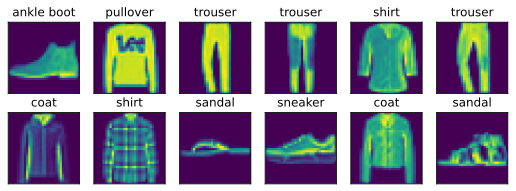

In [6]:
use_svg_display()
batch = next(iter(data.val_dataloader()))
data.visualize(batch, nrows=2, ncols=6)

# Model

In [7]:
from torch import nn

class Module(nn.Module, HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.cpu().detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [8]:
class Classifier(Module):
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions."""
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).type(Y.dtype)
        compare = (preds == Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
      Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
      Y = Y.reshape((-1,))
      return F.cross_entropy(
          Y_hat, Y, reduction='mean' if averaged else 'none')

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

class MLP(Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                      nn.ReLU(), nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

# Training

In [10]:
class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                      if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(batch)
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(batch)
            self.val_batch_idx += 1

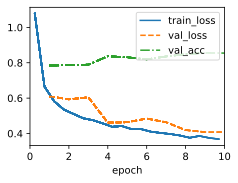

In [11]:
data = FashionMNIST(batch_size=256)
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

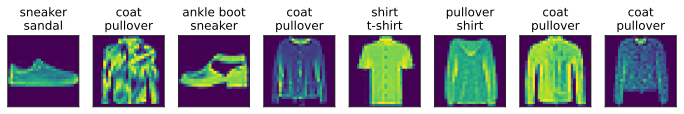

In [12]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

# With Dropout

In [13]:
class DropoutMLP(Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

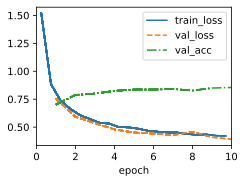

In [14]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
trainer.fit(model, data)